<a href="https://colab.research.google.com/github/scottspurlock/csc4466-s2024/blob/main/demos/day12_tutorial_image_registration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CSC 4466 Computer Vision
## Day 12 Demo: Homographies and image registration
Revisiting Russian image registration with a more robust approach.

While using SSD to align images based on translating color channels often worked well, it didn't always work well. Two problems:
1. Sometimes bright colors in one channel don't correlate with bright colors in another channel. For example, a blue coat may have high values in the blue channel and dark values in the red channel. A better solution than directly comparing pixel values with SSD is to find image features, e.g., using ORB, that are present in each channel regardless of color.
2. The camera may have moved in more complicated ways than just translation. A more general model might capture the camera motion more precisely. A homography can represent translation, rotation, and perspective transformation.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [ ]:
# Download the emir image from a Google Drive URL.
image_file = 'https://drive.google.com/uc?export=download&id=1o7vYTrvytGFqWPP3AHpRL172YWtxHCwV'

from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id='1o7vYTrvytGFqWPP3AHpRL172YWtxHCwV',
                                    dest_path='/content/emir.tif')

img = cv2.imread('emir.tif')
print()

if img is None:
    print('Unable to read image. Make sure it exists in the folder with this notebook.')
else:
    # To speed things up and make visualizing features easier
    img = cv2.resize(img, None, fx=0.25, fy=0.25)
    print('Image read with shape (rows, columns, color channels):', img.shape)



Image read with shape (rows, columns, color channels): (2407, 926, 3)


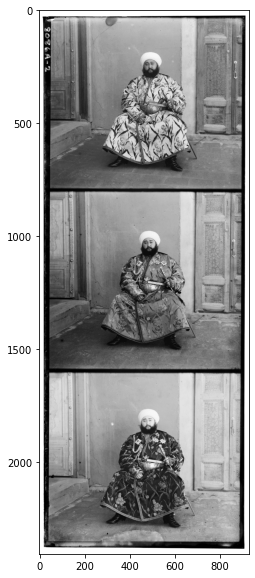

In [ ]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.figure(figsize=(10, 10))
plt.imshow(gray, cmap='gray')
plt.show()

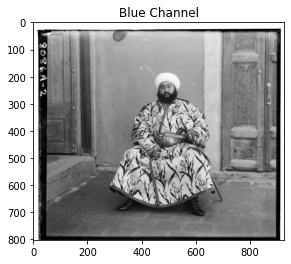

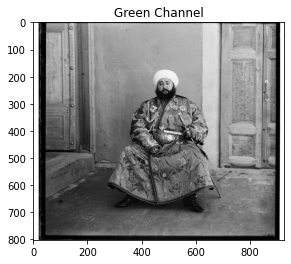

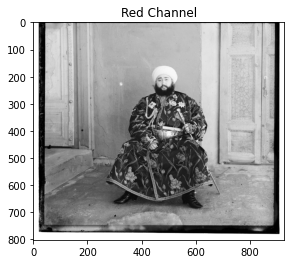

In [ ]:
# Split into thirds vertically
h, w = img.shape[:2]

offset = h // 3
blueC = gray[:offset, :]
greenC = gray[offset:2*offset, :]
redC = gray[2*offset:3*offset, :]

plt.imshow(blueC, cmap='gray')
plt.title('Blue Channel')
plt.show()
plt.imshow(greenC, cmap='gray')
plt.title('Green Channel')
plt.show()
plt.imshow(redC, cmap='gray')
plt.title('Red Channel')
plt.show()


In [ ]:
# create keypoint detector
MAX_FEATURES = 15000
SCALE_FACTOR = 1.2
SCORE_TYPE = cv2.ORB_HARRIS_SCORE
LEVELS = 8
FAST_THRESH = 20 # intensity difference (default 20)
EDGE_THRESH = 20 # How close to the edge can a feature be

orb = cv2.ORB_create(nfeatures=MAX_FEATURES,
                     scaleFactor=SCALE_FACTOR,
                     nlevels=LEVELS,
                     scoreType=SCORE_TYPE,
                     fastThreshold=FAST_THRESH,
                     edgeThreshold=EDGE_THRESH)

def find_and_disp_keypoints(I):
    kp, des = orb.detectAndCompute(I, None)

    print(f'Found {len(kp)} features...')

    disp = cv2.cvtColor(I, cv2.COLOR_GRAY2RGB)

    disp = cv2.drawKeypoints(disp, kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DEFAULT, color=(0, 255, 0))

    plt.imshow(disp)
    plt.title('Keypoints')
    plt.show()

    return kp, des

Found 13953 features...


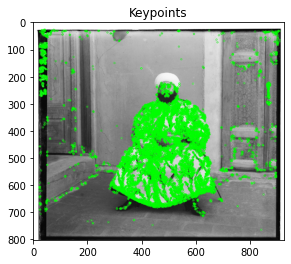

Found 12767 features...


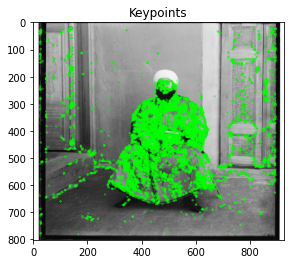

Found 13066 features...


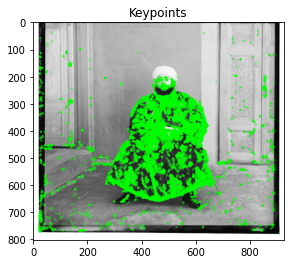

In [ ]:
kpB, desB = find_and_disp_keypoints(blueC)
kpG, desG = find_and_disp_keypoints(greenC)
kpR, desR = find_and_disp_keypoints(redC)

In [ ]:
# Brute force matching
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

def find_matches(im1, im2, kp1, kp2, des1, des2):
    matches = bf.match(des1, des2)
    print(f'Found {len(matches)} matches')

    # Sort matches by score
    matches.sort(key=lambda x: x.distance, reverse=False)

    # Remove not so good matches
    GOOD_MATCH_PERCENT = 0.05
    numGoodMatches = int(len(matches) * GOOD_MATCH_PERCENT)
    matches = matches[:numGoodMatches]

    # Draw top matches
    disp_matches = cv2.drawMatches(im1, kp1, im2, kp2, matches, None)

    plt.figure(figsize=(10, 10))
    plt.imshow(disp_matches)
    plt.show()

    return matches

In [ ]:
def find_homography(matches, kp1, kp2):
    ''' Given a set of matching keypoints from two images,
    finds a perspective transform from the first to the second.
    '''

    # Put the keypoint location of good matches into a NumPy array
    points1 = np.zeros((len(matches), 2), dtype=float)
    points2 = np.zeros((len(matches), 2), dtype=float)

    for i, match in enumerate(matches):
        points1[i, :] = kp1[match.queryIdx].pt
        points2[i, :] = kp2[match.trainIdx].pt

    # Find homography
    h, mask = cv2.findHomography(points1, points2, cv2.RANSAC)
    print('found homography:')
    print(h)
    return h

Green and blue
  finding matches
Found 3413 matches


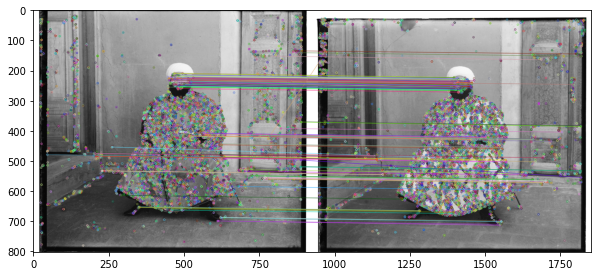

  finding homography to warp green to blue
found homography:
[[ 9.98183609e-01 -1.01282302e-03  4.92235938e+00]
 [ 6.01667054e-04  9.92283682e-01  1.29014262e+01]
 [ 4.56613599e-08 -1.18866888e-05  1.00000000e+00]]

Red and blue
  finding matches
Found 3258 matches


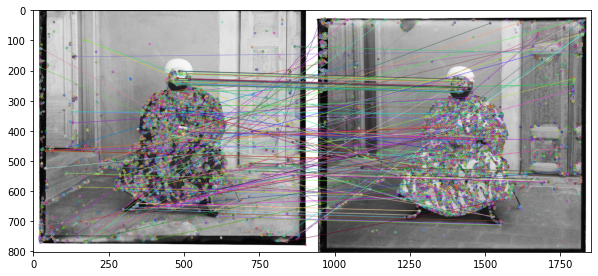

  finding homography to warp red to blue
found homography:
[[1.00597503e+00 1.16016604e-03 7.99975944e+00]
 [1.66032449e-03 1.00695389e+00 2.45169505e+01]
 [1.42499818e-06 7.94235065e-06 1.00000000e+00]]


In [ ]:
print('Green and blue')
print('  finding matches')
matches_GB = find_matches(greenC, blueC, kpG, kpB, desG, desB)
print('  finding homography to warp green to blue')
hGB = find_homography(matches_GB, kpG, kpB)

print()

print('Red and blue')
print('  finding matches')
matches_RB = find_matches(redC, blueC, kpR, kpB, desR, desB)
print('  finding homography to warp red to blue')
hRB = find_homography(matches_RB, kpR, kpB)

In [ ]:
def warp_image(im, h):
    ''' Warp image im according to homography h
    '''
    height, width = im.shape[:2]
    warped = cv2.warpPerspective(im, h, (width, height))
    return warped

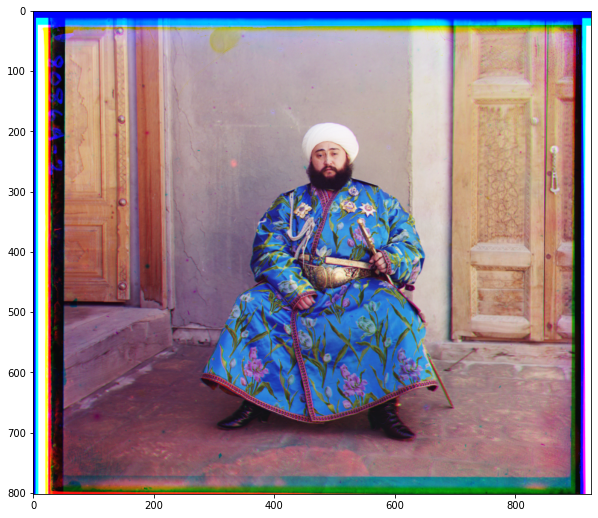

In [ ]:
alignedG = warp_image(greenC, hGB)
alignedR = warp_image(redC, hRB)
merged = cv2.merge((alignedR, alignedG, blueC))

plt.figure(figsize=(10, 10))
plt.imshow(merged)
plt.show()